# Prediction using CNN feature extraction

This notebook attempts to predict Cell Type abundance from the Image data.

It splits the image into patches, and uses CNN to extract feature from each. 

Extracing the CNN features takes a long time - about 40 minutes without GPU. We use pickle files to store it and load it quickly during development.

In [1]:
import h5py
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# -----------------------------
# 1. Functions for Patch Extraction and CNN Features
# -----------------------------
def extract_patch(image, center, patch_size):
    """
    Extract a square patch from the image centered at the given coordinate.
    Assumes image shape is (height, width, channels) and center is (x, y).
    """
    x, y = int(center[0]), int(center[1])
    half_size = patch_size // 2
    # Ensure indices are within bounds
    y_min = max(y - half_size, 0)
    y_max = min(y + half_size, image.shape[0])
    x_min = max(x - half_size, 0)
    x_max = min(x + half_size, image.shape[1])
    patch = image[y_min:y_max, x_min:x_max, :]
    return patch

def extract_cnn_features(patch, cnn_model):
    """
    Resize, preprocess, and extract CNN features from a given image patch.
    
    Parameters:
      patch (ndarray): The image patch to process.
      cnn_model (Model): The pre-trained CNN model for feature extraction.
      
    Returns:
      features (ndarray): Flattened feature vector from the CNN.
    """
    # Resize patch to the input size expected by ResNet50 (e.g., 224x224)
    patch_resized = cv2.resize(patch, (224, 224))
    patch_preprocessed = preprocess_input(np.expand_dims(patch_resized, axis=0))
    features = cnn_model.predict(patch_preprocessed, verbose=0)
    return features.flatten()

# -----------------------------
# 2. Custom Transformer to Extract CNN Features from Patches
# -----------------------------
class PatchFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image, patch_size, cnn_model):
        """
        Parameters:
          image (ndarray): The whole-slide HE image as a numpy array.
          patch_size (int): Size (in pixels) of the square patch to extract.
          cnn_model (Model): Pre-trained CNN model for feature extraction.
        """
        self.image = image
        self.patch_size = patch_size
        self.cnn_model = cnn_model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Collect all resized patches in a list
        patches = []
        for coord in X:
            patch = extract_patch(self.image, coord, self.patch_size)
            # Resize patch to the input size expected by ResNet50 (224x224)
            patch_resized = cv2.resize(patch, (224, 224))
            patches.append(patch_resized)
        # Convert list to numpy array: shape (n_samples, 224, 224, channels)
        patches = np.array(patches)
        # Preprocess all patches at once using the appropriate preprocessing function
        patches_preprocessed = preprocess_input(patches.astype(np.float32))
        # Run the CNN model once on the entire batch
        features = self.cnn_model.predict(patches_preprocessed, verbose=0)
        # Flatten features if necessary (ResNet50 with pooling='avg' already outputs 2D arrays)
        features = features.reshape(features.shape[0], -1)
        return features
        
# -----------------------------
# 3. Pipeline Class for the Elucidata Challenge with Caching and Visualization Options
# -----------------------------
class CellTypePipeline:
    """
    Pipeline for loading data, extracting image patch features using a CNN,
    training a multi-output regression model, and generating a submission file.
    
    Optionally, CNN features can be cached (saved/loaded) using pickle to speed up re-runs.
    Additional visualization methods are provided to verify that the spot coordinates 
    and extracted patches align with the HE slide image.
    """
    
    def __init__(self, h5_file_path, patch_size=64):
        self.h5_file_path = h5_file_path
        self.patch_size = patch_size
        self.train_spot_tables = {}
        self.train_images = {}
        self.cell_type_columns = None
        self.cnn_model = None  # To be initialized
        self.feature_extractor_pipeline = None

    def initialize_cnn_model(self):
        """
        Initialize a pre-trained ResNet50 model (without top layers) for feature extraction.
        """
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        self.cnn_model = Model(inputs=base_model.input, outputs=base_model.output)
        print("CNN feature extractor initialized.")

    def load_train_data(self):
        """
        Load training spot data from the H5 file and store each slide as a DataFrame.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            train_spots = f["spots/Train"]
            for slide_name in train_spots.keys():
                spot_array = np.array(train_spots[slide_name])
                df = pd.DataFrame(spot_array, columns=["x", "y"] + [f"C{i}" for i in range(1, 36)])
                self.train_spot_tables[slide_name] = df
        print("Training spot data loaded successfully.")
        
    def load_train_images(self):
        """
        Load training HE images from the H5 file.
        Adjust the key if your H5 file uses a different naming convention.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            # Adjust key if necessary (e.g., f["images/Train"] if needed)
            train_imgs = f["images/Train"]
            for slide_name in train_imgs.keys():
                image_array = np.array(train_imgs[slide_name])
                self.train_images[slide_name] = image_array
        print("Training images loaded successfully.")

    def load_test_data(self, slide_id):
        """
        Load test spot data for a given slide.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            test_spots = f["spots/Test"]
            if slide_id not in test_spots:
                raise ValueError(f"Slide {slide_id} not found in test spot data.")
            spot_array = np.array(test_spots[slide_id])
            test_df = pd.DataFrame(spot_array, columns=["x", "y"])
        print(f"Test spot data for slide {slide_id} loaded successfully.")
        return test_df

    def load_test_image(self, slide_id):
        """
        Load test HE image for a given slide.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            test_imgs = f["images/Test"]
            if slide_id not in test_imgs:
                raise ValueError(f"Slide {slide_id} not found in test images.")
            image_array = np.array(test_imgs[slide_id])
        print(f"Test image for slide {slide_id} loaded successfully.")
        return image_array

    def prepare_training_set(self, slide_id='S_1', cache_path=None):
        """
        Prepare training features and targets for a given slide.
        Uses the HE image to extract patches and then CNN features.
        
        If cache_path is provided and exists, the method will load cached features.
        Otherwise, it will compute the features and then save them to the provided cache_path.
        """
        if cache_path is not None and os.path.exists(cache_path):
            print(f"Loading cached training features from {cache_path} for slide {slide_id} ...")
            with open(cache_path, "rb") as f:
                X_features, y = pickle.load(f)
            return X_features, y
        
        if slide_id not in self.train_spot_tables:
            raise ValueError(f"Slide {slide_id} not found in training spot data.")
        if slide_id not in self.train_images:
            raise ValueError(f"Slide {slide_id} image not loaded.")
            
        df = self.train_spot_tables[slide_id]
        # Assume first two columns are coordinates and the rest are cell type abundances.
        feature_cols = ['x', 'y']
        target_cols = [col for col in df.columns if col not in feature_cols]
        self.cell_type_columns = target_cols  # Assumed consistent across slides
        
        # Extract coordinates (for patch extraction)
        X_coords = df[feature_cols].values.astype(float)
        # Cell type abundance targets
        y = df[target_cols].values.astype(float)
        
        # Build a feature extractor pipeline for this slide.
        he_image = self.train_images[slide_id]
        patch_extractor = PatchFeatureExtractor(he_image, self.patch_size, self.cnn_model)
        self.feature_extractor_pipeline = Pipeline([
            ('patch_extractor', patch_extractor),
            ('scaler', StandardScaler())
        ])
        # Extract features for training
        print(f"Extracting CNN features for slide {slide_id} ...")
        X_features = self.feature_extractor_pipeline.fit_transform(X_coords)
        
        if cache_path is not None:
            print(f"Saving training features for slide {slide_id} to {cache_path} ...")
            with open(cache_path, "wb") as f:
                pickle.dump((X_features, y), f)
                
        print(f"Extracted CNN features for slide {slide_id}.")
        return X_features, y

    def prepare_all_training_set(self, cache_dir=None):
        """
        Prepare training features and targets for all slides in the training set (S_1 to S_6).
        If cache_dir is provided, each slide will use a separate cache file named train_features_<slide_id>.pkl.
        Returns:
            X_all (ndarray): Concatenated features for all slides.
            y_all (ndarray): Concatenated target values for all slides.
        """
        X_list = []
        y_list = []
        # Ensure slides are processed in order (S_1, S_2, ... S_6)
        for slide_id in sorted(self.train_spot_tables.keys()):
            slide_cache_path = os.path.join(cache_dir, f"train_features_{slide_id}.pkl") if cache_dir else None
            X, y = self.prepare_training_set(slide_id=slide_id, cache_path=slide_cache_path)
            X_list.append(X)
            y_list.append(y)
        X_all = np.concatenate(X_list, axis=0)
        y_all = np.concatenate(y_list, axis=0)
        print("All training features extracted and concatenated.")
        return X_all, y_all

    def build_regression_pipeline(self):
        """
        Build and return a regression pipeline that uses the pre-extracted CNN features.
        """
        pipeline = Pipeline([
            ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)))
        ])
        return pipeline

    def train(self, X, y):
        """
        Train the regression model on the provided features and targets.
        """
        reg_pipeline = self.build_regression_pipeline()
        reg_pipeline.fit(X, y)
        print("Regression model training complete.")
        return reg_pipeline

    def predict(self, reg_model, X_test):
        """
        Predict cell type abundances on test features.
        """
        predictions = reg_model.predict(X_test)
        return predictions

    def create_submission(self, test_df, predictions, submission_filename="submission.csv"):
        """
        Create a submission CSV file with predicted cell type abundances.
        """
        pred_df = pd.DataFrame(predictions, columns=self.cell_type_columns, index=test_df.index)
        pred_df.insert(0, 'ID', pred_df.index)
        pred_df.to_csv(submission_filename, index=False)
        print(f"Submission file '{submission_filename}' created!")

    # -----------------------------
    # Visualization Methods
    # -----------------------------
    def visualize_spot_overlay(self, slide_id, flip_y=False):
        """
        Visualize the overlay of spot coordinates on the HE slide image.
        Optionally, flip the y-axis if needed.
        """
        if slide_id not in self.train_images or slide_id not in self.train_spot_tables:
            raise ValueError(f"Slide {slide_id} data not found.")
        image = self.train_images[slide_id]
        df = self.train_spot_tables[slide_id]
        coords = df[['x', 'y']].values.astype(float)
        if flip_y:
            coords[:, 1] = image.shape[0] - coords[:, 1]
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.scatter(coords[:, 0], coords[:, 1], marker='o', color='red', s=25)
        plt.title(f"Overlay of Spot Coordinates for Slide {slide_id}")
        plt.show()

    def visualize_extracted_patches(self, slide_id, num_patches=5, flip_y=False):
        """
        Visualize a few extracted patches from the slide to verify correct extraction.
        """
        if slide_id not in self.train_images or slide_id not in self.train_spot_tables:
            raise ValueError(f"Slide {slide_id} data not found.")
        image = self.train_images[slide_id]
        df = self.train_spot_tables[slide_id]
        coords = df[['x', 'y']].values.astype(float)
        if flip_y:
            coords[:, 1] = image.shape[0] - coords[:, 1]
        fig, axes = plt.subplots(1, num_patches, figsize=(num_patches * 3, 3))
        for i in range(num_patches):
            patch = extract_patch(image, coords[i], self.patch_size)
            axes[i].imshow(patch)
            axes[i].set_title(f"Patch {i}")
            axes[i].axis("off")
        plt.suptitle(f"Extracted Patches for Slide {slide_id}")
        plt.show()
    
    def visualize_cnn_input(self, slide_id, index=0, flip_y=False):
        """
        Visualize the resized patch for a given spot index with an overlay of the spot position,
        and plot the distribution of the 35 cell type abundances for that spot.
        """
        if slide_id not in self.train_images or slide_id not in self.train_spot_tables:
            raise ValueError(f"Slide {slide_id} data not found.")
        image = self.train_images[slide_id]
        df = self.train_spot_tables[slide_id]
        coords = df[['x', 'y']].values.astype(float)
        if flip_y:
            coords[:, 1] = image.shape[0] - coords[:, 1]
        coord = coords[index]
        
        # Calculate patch boundaries and extract patch
        half_size = self.patch_size // 2
        x = int(coord[0])
        y = int(coord[1])
        x_min = max(x - half_size, 0)
        y_min = max(y - half_size, 0)
        patch = extract_patch(image, coord, self.patch_size)

        # Print the patch's top-left coordinates
        print(f"Patch top-left coordinates: (x_min: {x_min}, y_min: {y_min})")
        
        # Resize patch to CNN input size (e.g., 224x224)
        patch_resized = cv2.resize(patch, (224, 224))
        
        # Compute the spot's relative position within the patch
        rel_x = x - x_min
        rel_y = y - y_min
        scale_x = 224 / patch.shape[1]
        scale_y = 224 / patch.shape[0]
        spot_resized_x = rel_x * scale_x
        spot_resized_y = rel_y * scale_y
    
        # Retrieve cell type abundancies for this spot.
        # Assuming the first two columns are x and y, and the rest are cell type abundancies.
        abundances = df.iloc[index][[col for col in df.columns if col not in ['x', 'y']]]
        
        # Create two subplots: left for the image patch, right for the bar chart.
        fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Left subplot: Resized patch with the spot position overlaid.
        ax_img.imshow(patch_resized)
        ax_img.scatter([spot_resized_x], [spot_resized_y], marker='x', color='red', s=50)
        ax_img.set_title(f"Resized Patch (Index {index})")
        ax_img.axis("off")
        
        # Right subplot: Bar chart of the cell type abundancies.
        cell_types = abundances.index.tolist()  # e.g., ['C1', 'C2', ..., 'C35']
        ax_bar.bar(cell_types, abundances.values)
        ax_bar.set_title("Cell Type Abundance Distribution")
        ax_bar.set_xticklabels(cell_types, rotation=90)
        ax_bar.set_ylabel("Abundance")
        
        plt.tight_layout()
        plt.show()



In [2]:

# -----------------------------
# 4. Example Usage with Caching and Visualization Options
# -----------------------------

# Path to the provided H5 data file
h5_file_path = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"

# Optionally specify a directory for caching training features (for slides S_1 to S_6)
train_cache_dir = "train_features_cache"
os.makedirs(train_cache_dir, exist_ok=True)
test_cache_path = "test_features_S_7.pkl"      # For slide S_7 test features

# Initialize the pipeline with desired patch size (in pixels)
pipeline_obj = CellTypePipeline(h5_file_path, patch_size=64)

# Initialize the CNN feature extractor (ResNet50)
pipeline_obj.initialize_cnn_model()

# Load training spots and images
pipeline_obj.load_train_data()
pipeline_obj.load_train_images()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
CNN feature extractor initialized.
Training spot data loaded successfully.
Training images loaded successfully.


### Patches in Slide 1

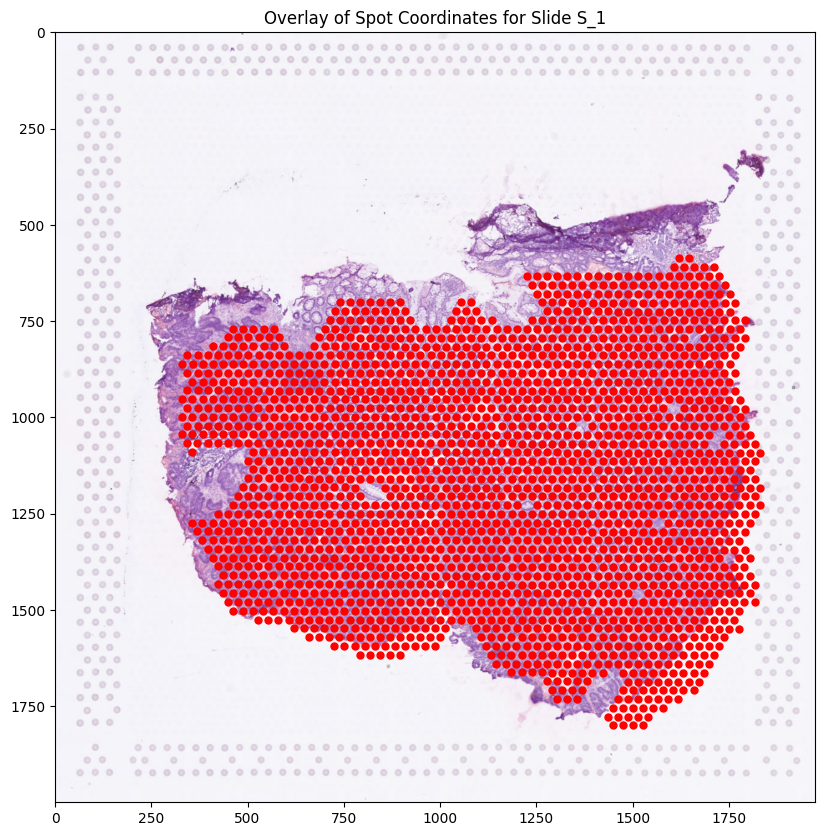

In [3]:


# Optional: Visualize the overlay of spot coordinates on a training slide (e.g., S_1)
pipeline_obj.visualize_spot_overlay(slide_id='S_1', flip_y=False)




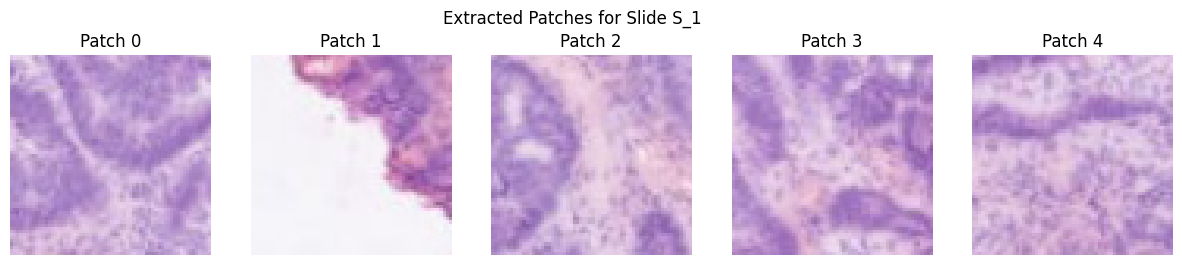

In [4]:

# Optional: Visualize a few extracted patches from a training slide (e.g., S_1)
pipeline_obj.visualize_extracted_patches(slide_id='S_1', num_patches=5, flip_y=False)



Patch top-left coordinates: (x_min: 1667, y_min: 647)


<ipython-input-1-e1dffafab98f>:368: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(cell_types, rotation=90)


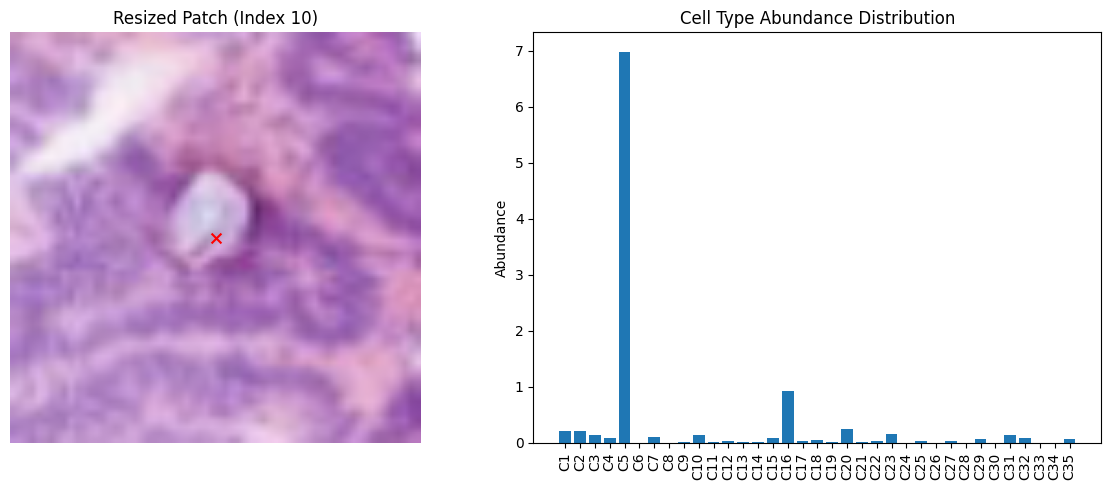

In [5]:
# Optional: Visualize the CNN input (resized patch) for a specific spot (e.g., index 0 from S_1)
pipeline_obj.visualize_cnn_input(slide_id='S_1', index=10, flip_y=False)

Patch top-left coordinates: (x_min: 1667, y_min: 647)


<ipython-input-1-e1dffafab98f>:368: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(cell_types, rotation=90)


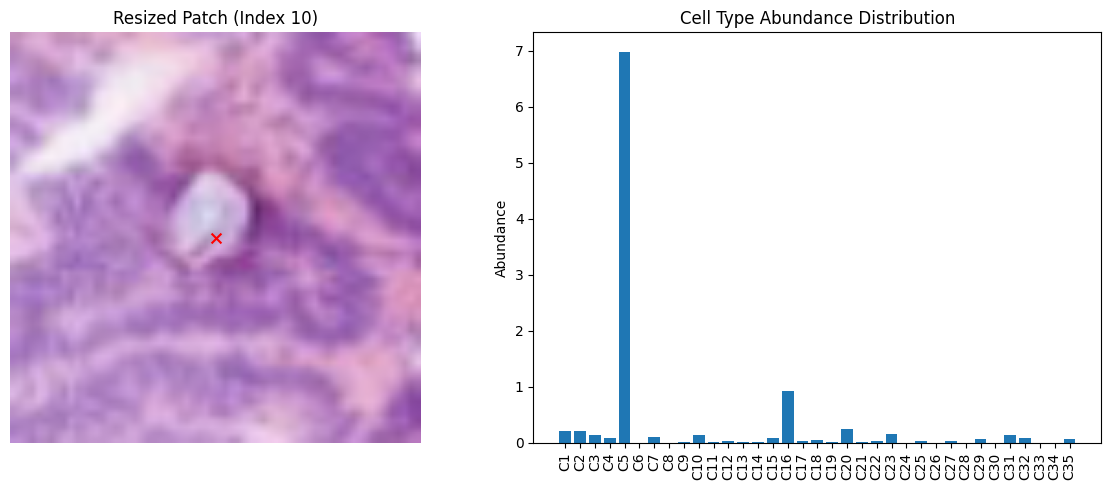

In [6]:
pipeline_obj.visualize_cnn_input(slide_id='S_1', index=10, flip_y=False)


### Patches in Slide 2

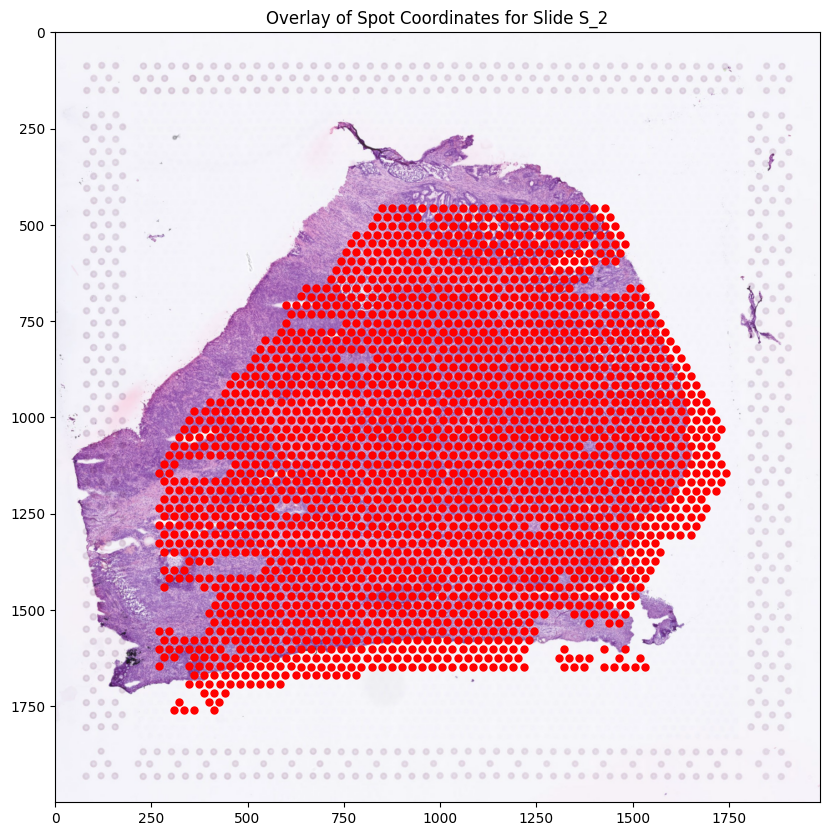

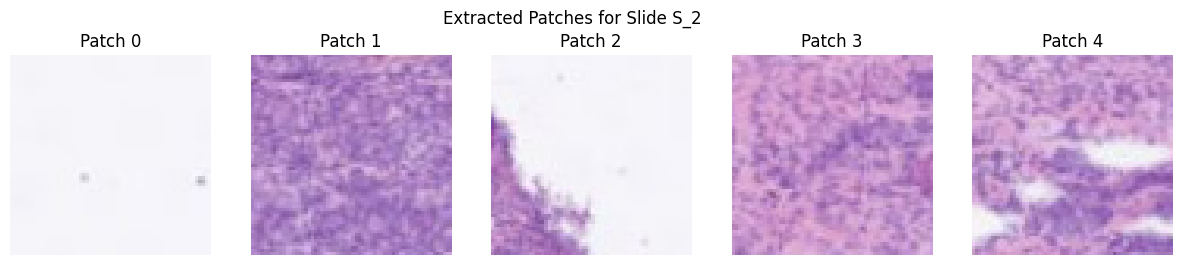

In [7]:
pipeline_obj.visualize_spot_overlay(slide_id='S_2', flip_y=False)
pipeline_obj.visualize_extracted_patches(slide_id='S_2', num_patches=5, flip_y=False)


Patch top-left coordinates: (x_min: 1540, y_min: 1318)


<ipython-input-1-e1dffafab98f>:368: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(cell_types, rotation=90)


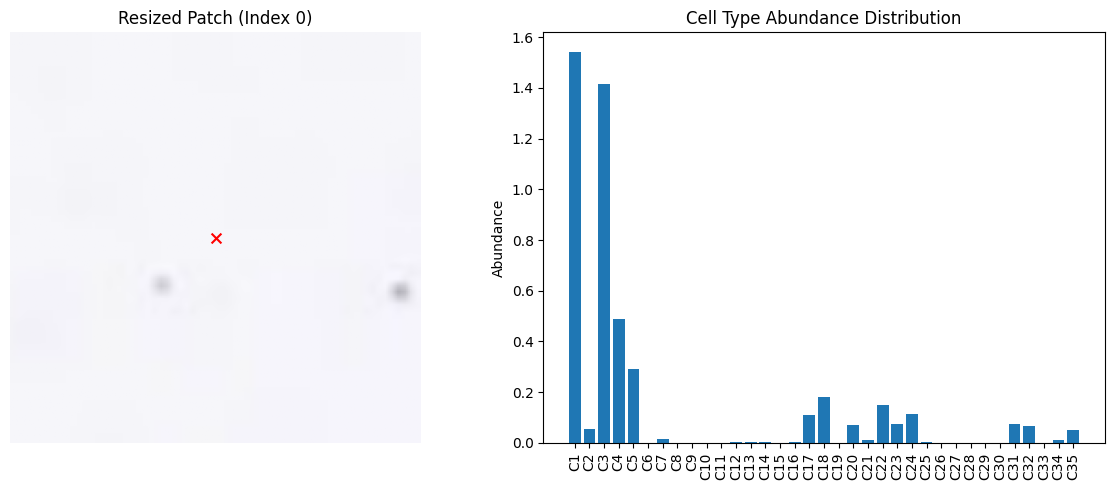

In [8]:
pipeline_obj.visualize_cnn_input(slide_id='S_2', index=0, flip_y=False)


Patch top-left coordinates: (x_min: 1159, y_min: 910)


<ipython-input-1-e1dffafab98f>:368: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(cell_types, rotation=90)


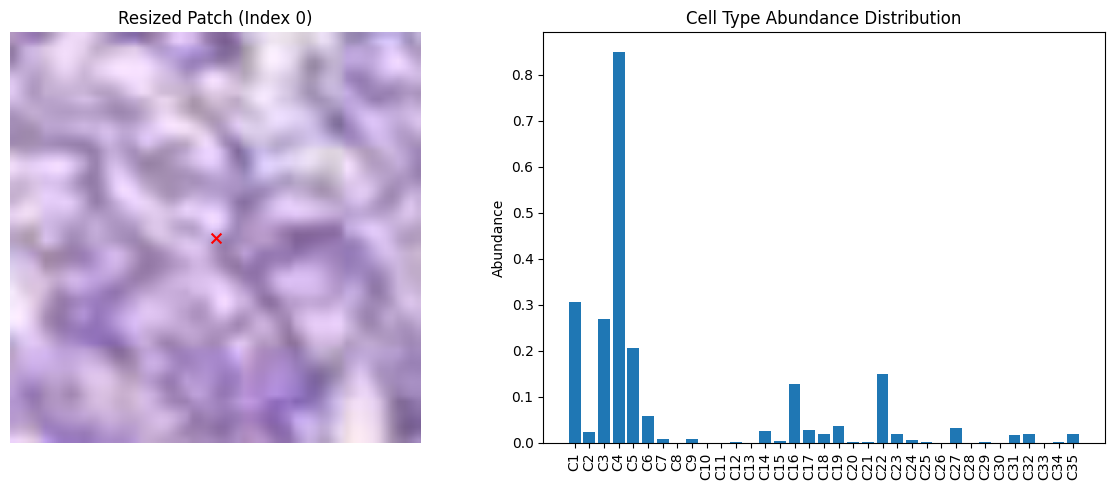

In [9]:
pipeline_obj.visualize_cnn_input(slide_id='S_3', index=0, flip_y=False)


Patch top-left coordinates: (x_min: 416, y_min: 1449)


<ipython-input-1-e1dffafab98f>:368: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(cell_types, rotation=90)


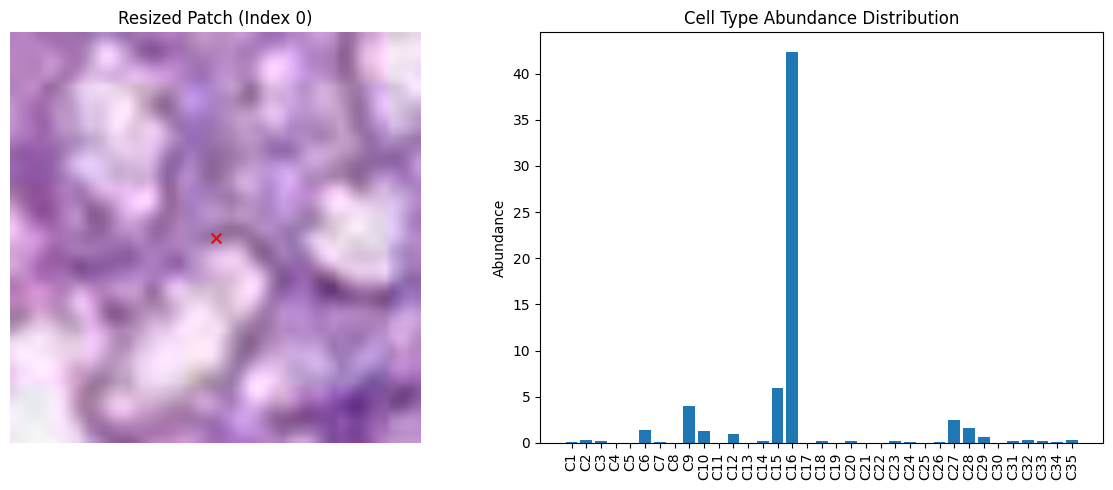

In [10]:
pipeline_obj.visualize_cnn_input(slide_id='S_4', index=0, flip_y=False)


Patch top-left coordinates: (x_min: 1463, y_min: 1229)


<ipython-input-1-e1dffafab98f>:368: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(cell_types, rotation=90)


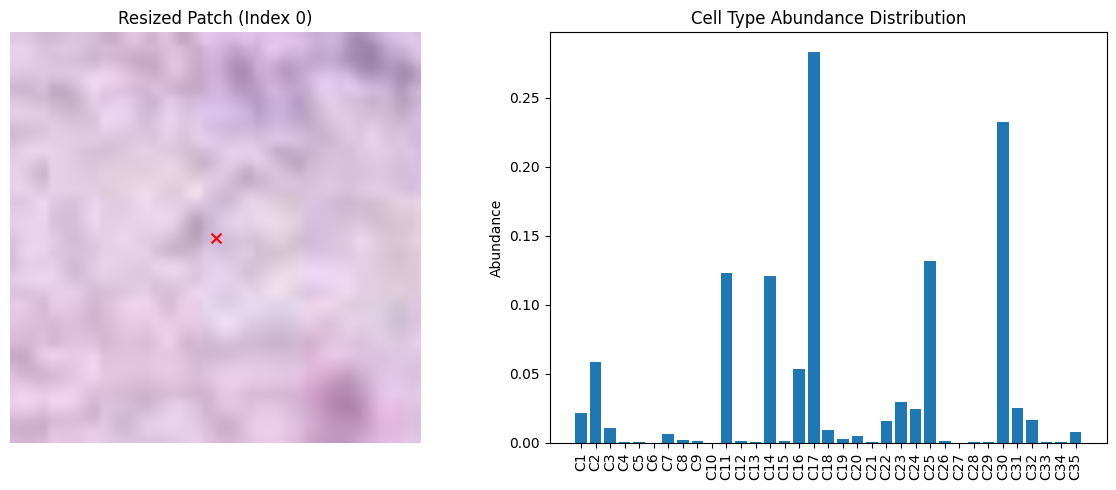

In [11]:
pipeline_obj.visualize_cnn_input(slide_id='S_5', index=0, flip_y=False)


In [12]:
skip_training = True

if not skip_training:
    # Prepare training features and targets from all slides (S_1 to S_6)
    X_train, y_train = pipeline_obj.prepare_all_training_set(cache_dir=train_cache_dir)

    # Train regression model on extracted CNN features
    reg_model = pipeline_obj.train(X_train, y_train)
    
    # Load test data and image for slide S_7 (as per challenge description)
    test_df = pipeline_obj.load_test_data(slide_id='S_7')
    test_image = pipeline_obj.load_test_image(slide_id='S_7')



In [13]:
if not skip_training:
    X_train

In [14]:
if not skip_training:
    # Build a feature extractor for test slide using its HE image
    test_patch_extractor = PatchFeatureExtractor(test_image, pipeline_obj.patch_size, pipeline_obj.cnn_model)
    test_feature_pipeline = Pipeline([
        ('patch_extractor', test_patch_extractor),
        ('scaler', StandardScaler())
    ])
    X_test_coords = test_df[['x', 'y']].values.astype(float)



In [15]:
if not skip_training:
    # Check for cached test features
    if os.path.exists(test_cache_path):
        print(f"Loading cached test features from {test_cache_path} ...")
        with open(test_cache_path, "rb") as f:
            X_test_features = pickle.load(f)
    else:
        print("Extracting CNN features for test data ...")
        X_test_features = test_feature_pipeline.fit_transform(X_test_coords)
        print(f"Saving test features to {test_cache_path} ...")
        with open(test_cache_path, "wb") as f:
            pickle.dump(X_test_features, f)


In [16]:
if not skip_training:

    # Predict cell type abundances for test data
    predictions = pipeline_obj.predict(reg_model, X_test_features)
    
    # Create submission file
    pipeline_obj.create_submission(test_df, predictions, submission_filename="submission.csv")